In [1]:
import numpy as np
import torch

NUM_CLASSES = 3

device = "cuda:0"

device = torch.device(device if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
from torch.utils.data import Dataset
import os
from PIL import Image


class SupervisedDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.image_paths = os.listdir(image_folder)
        self.mask_paths = os.listdir(mask_folder)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_folder, self.image_paths[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_paths[idx])
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        img = np.array(img)
        mask = np.array(mask)

        mask[mask == 128] = 1
        mask[mask == 255] = 2

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert to torch tensor
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()

        return img, mask

In [3]:
class UnsupervisedDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = os.listdir(image_folder)
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_paths[idx])
        
        img = Image.open(img_path)
        img = np.array(img)

        if self.transform:
            img = self.transform(image=img)['image']

        # convert to torch tensor
        img = torch.from_numpy(img).permute(2, 0, 1)

        return img

In [4]:
import albumentations as A

SIZE = 320
labeled_transform = A.Compose([
    A.Resize(320, 320),
    ])

unlabeled_transform = A.Compose([
    A.Resize(320, 320),
    ])

In [5]:
labeled_image_path = r'REFUGE2\train\images'
labeled_mask_path = r'REFUGE2\train\mask'

labeled_train_dataset = SupervisedDataset(labeled_image_path, labeled_mask_path, 
                            transform=labeled_transform)

unlabeled_image_path = r'REFUGE2\val\images'

unlabeled_train_dataset = UnsupervisedDataset(unlabeled_image_path, transform=unlabeled_transform)

val_image_path = r'REFUGE2\val\images'
val_mask_path = r'REFUGE2\val\mask'

val_dataset = SupervisedDataset(val_image_path, val_mask_path,
                            transform=labeled_transform)

In [6]:
a, b = labeled_train_dataset[42]

a.shape, b.shape, a.dtype, b.dtype, b.unique()

(torch.Size([3, 320, 320]),
 torch.Size([320, 320]),
 torch.float32,
 torch.int64,
 tensor([0, 1, 2]))

In [7]:
from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union, cast
from functools import partial
from torch import Tensor
import torch
from torchvision import transforms
import numpy as np
from operator import itemgetter, mul

def uniq(a: Tensor) -> Set:
    return set(torch.unique(a.cpu()).numpy())

def sset(a: Tensor, sub) -> bool:
    return uniq(a).issubset(sub)

def simplex(t: Tensor, axis=1) -> bool:
    _sum = cast(Tensor, t.sum(axis).type(torch.float32))
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)

def one_hot(t: Tensor, axis=1) -> bool:
    return simplex(t, axis) and sset(t, [0, 1])

def class2one_hot(seg: Tensor, K: int) -> Tensor:
    # Breaking change but otherwise can't deal with both 2d and 3d
    # if len(seg.shape) == 3:  # Only w, h, d, used by the dataloader
    #     return class2one_hot(seg.unsqueeze(dim=0), K)[0]

    assert sset(seg, list(range(K))), (uniq(seg), K)

    b, *img_shape = seg.shape  # type: Tuple[int, ...]

    device = seg.device
    res = torch.zeros((b, K, *img_shape), dtype=torch.int32, device=device).scatter_(1, seg[:, None, ...], 1)

    assert res.shape == (b, K, *img_shape)
    assert one_hot(res)

    return res

def gt_transform(resolution: Tuple[float, ...], K: int):
        return transforms.Compose([
                lambda img: np.array(img.cpu())[...],
                lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],  # Add one dimension to simulate batch
                partial(class2one_hot, K=K),
                itemgetter(0)  # Then pop the element to go back to img shape
        ])
from scipy.ndimage import distance_transform_edt as eucl_distance

def one_hot2dist(seg: np.ndarray, resolution: Tuple[float, float, float] = None,
                 dtype=None) -> np.ndarray:
    assert one_hot(torch.tensor(seg), axis=0)
    K: int = len(seg)

    res = np.zeros_like(seg, dtype=dtype)
    for k in range(K):
        posmask = seg[k].astype(bool)

        if posmask.any():
            negmask = ~posmask
            res[k] = eucl_distance(negmask, sampling=resolution) * negmask \
                - (eucl_distance(posmask, sampling=resolution) - 1) * posmask
        # The idea is to leave blank the negative classes
        # since this is one-hot encoded, another class will supervise that pixel

    return res

def dist_map_transform(resolution: Tuple[float, ...], K: int):
        return transforms.Compose([
                gt_transform(resolution, K),
                lambda t: t.cpu().numpy(),
                partial(one_hot2dist, resolution=resolution),
                lambda nd: torch.tensor(nd, dtype=torch.float32).to(device)
        ])

disttransform = dist_map_transform([1, 1], NUM_CLASSES)

In [8]:
from torch import Tensor, einsum

class GeneralizedDiceLoss():
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc: List[int] = kwargs["idc"]
        print(f"Initialized {self.__class__.__name__} with {kwargs}")

    def __call__(self, probs: Tensor, target: Tensor) -> Tensor:
        assert simplex(probs) and simplex(target)

        pc = probs[:, self.idc, ...].type(torch.float32)
        tc = target[:, self.idc, ...].type(torch.float32)

        w: Tensor = 1 / ((einsum("bkwh->bk", tc).type(torch.float32) + 1e-10) ** 2)
        intersection: Tensor = w * einsum("bkwh,bkwh->bk", pc, tc)
        union: Tensor = w * (einsum("bkwh->bk", pc) + einsum("bkwh->bk", tc))

        divided: Tensor = 1 - 2 * (einsum("bk->b", intersection) + 1e-10) / (einsum("bk->b", union) + 1e-10)

        loss = divided.mean()

        return loss


In [9]:
class SurfaceLoss():
    def __init__(self, **kwargs):
        # Self.idc is used to filter out some classes of the target mask. Use fancy indexing
        self.idc: List[int] = kwargs["idc"]
        print(f"Initialized {self.__class__.__name__} with {kwargs}")

    def __call__(self, probs: Tensor, dist_maps: Tensor) -> Tensor:
        assert simplex(probs)
        assert not one_hot(dist_maps)

        pc = probs[:, self.idc, ...].type(torch.float32)
        dc = dist_maps[:, self.idc, ...].type(torch.float32)

        multipled = einsum("bkwh,bkwh->bkwh", pc, dc)

        loss = multipled.mean()

        return loss

BoundaryLoss = SurfaceLoss

In [10]:
def calculate_loss(y_pred, labels, generalized_dice_loss_fn, boundary_loss_fn, alpha):
    one_hot_labels = torch.stack([class2one_hot(label.unsqueeze(0), NUM_CLASSES).squeeze(0) for label in labels])
    dist_map_labels = torch.stack([disttransform(label) for label in labels])
    pred_probs = torch.softmax(y_pred, dim=1)

    gdl_loss = generalized_dice_loss_fn(pred_probs, one_hot_labels)
    bl_loss = boundary_loss_fn(pred_probs, dist_map_labels)

    loss = gdl_loss + alpha*bl_loss

    return loss

In [11]:
def augment_image(image, augmentation):
    """Apply augmentation to an image."""
    return augmentation(image=image)['image']

def augment_batch(batch, augmentation):
    """Apply augmentation to a batch of images."""
    batch_np = batch.permute(0, 2, 3, 1).cpu().numpy()
    augmented_images = [augment_image(image, augmentation).astype(np.float32) for image in batch_np]
    return torch.tensor(np.stack(augmented_images)).permute(0, 3, 1, 2).to(device)

In [12]:
def unsupervised_train_step(unlabeled_images, model, generalized_dice_loss_fn, boundary_loss_fn, 
                            weak_aug, strong_aug, alpha, threshold):
    u_w = augment_batch(unlabeled_images, weak_aug)
    with torch.no_grad():
        y_weak = model(u_w)
    
        y_weak = torch.softmax(y_weak, dim=1)

    # get pixel-wise max probability
    q_b = torch.max(y_weak, dim=1)[0]

    # get image-wise mean of pixel-wise max probability
    q_b_mean = torch.mean(q_b, dim=(1, 2))

    mask = q_b_mean >= threshold

    # return 0 loss if no image is above threshold
    if mask.sum() == 0:
        unsupervised_loss = torch.tensor(0).to(device)
        return unsupervised_loss, mask.sum() / len(mask)

    psudeo_labels = torch.argmax(y_weak, dim=1)[mask]
    
    u_s = augment_batch(unlabeled_images[mask], strong_aug)
    y_strong = model(u_s)


    unsupervised_loss = calculate_loss(y_strong, psudeo_labels, generalized_dice_loss_fn, boundary_loss_fn, alpha)

    return unsupervised_loss, mask.sum() / len(mask)


In [13]:
def supervised_train_step(labeled_images, labeled_masks, model, generalized_dice_loss_fn, boundary_loss_fn, alpha):
    y_pred = model(labeled_images)
    supervised_loss = calculate_loss(y_pred, labeled_masks, generalized_dice_loss_fn, boundary_loss_fn, alpha)

    return supervised_loss

In [14]:
def train_step(labeled_batch, unlabeled_batch, model, optimizer,
                generalized_dice_loss_fn, boundary_loss_fn, weak_aug, strong_aug,
                alpha, threshold, lambda_u, device ):
    
    labeled_images, labeled_masks = labeled_batch
    unlabeled_images = unlabeled_batch

    labeled_images = labeled_images.to(device)
    labeled_masks = labeled_masks.to(device)
    unlabeled_images = unlabeled_images.to(device)

    optimizer.zero_grad()

    unsupervised_loss, mask_percent = unsupervised_train_step(unlabeled_images, model, generalized_dice_loss_fn, boundary_loss_fn, weak_aug, strong_aug, alpha, threshold)

    supervised_loss = supervised_train_step(labeled_images, labeled_masks, model, generalized_dice_loss_fn, boundary_loss_fn, alpha)

    total_loss = supervised_loss + lambda_u*unsupervised_loss
    
    total_loss.backward()
    optimizer.step()

    return total_loss.item(), supervised_loss.item(), unsupervised_loss.item(), mask_percent


In [ ]:
def calculate_iou(y_pred, labels):
    y_pred = torch.argmax(y_pred, dim=1)
    intersection = torch.logical_and(y_pred, labels).sum()
    union = torch.logical_or(y_pred, labels).sum()

    iou = intersection / union

    return iou

In [15]:
from tqdm import tqdm

def validate(val_loader, model, generalized_dice_loss_fn, boundary_loss_fn, alpha, device):
    model.eval()
    loss_sum = 0
    iou_sum = 0
    count = 0
    with torch.inference_mode():
        for images, masks in tqdm(val_loader, total=len(val_loader)):
            images = images.to(device)
            masks = masks.to(device)

            y_pred = model(images)
            loss = calculate_loss(y_pred, masks, generalized_dice_loss_fn, boundary_loss_fn, alpha)
            iou = calculate_iou(y_pred, masks)
            count += 1

    return loss_sum / count, iou_sum / count

In [16]:
from tqdm import tqdm

def train_fixmatch(labeled_train_loader, unlabeled_train_loader, val_loader,
                    model, optimizer, generalized_dice_loss_fn, boundary_loss_fn, 
                    weak_aug, strong_aug, alpha: float, threshold: float, lambda_u: float,
                    device, max_epochs: int, early_stopping_patience: int, file_path: str):

    best_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(max_epochs):
        L_sum = 0
        L_u_sum = 0
        L_s_sum = 0
        mask_percent_sum = 0
        count = 0

        model.train()
        for labeled_batch, unlabeled_batch in tqdm(zip(labeled_train_loader, unlabeled_train_loader), total=len(labeled_train_loader)):
            L, L_s, L_u, mask_percent = train_step(labeled_batch, unlabeled_batch, model, optimizer,
                        generalized_dice_loss_fn, boundary_loss_fn, 
                        weak_aug, strong_aug, alpha, threshold, lambda_u, device)
            L_sum += L
            L_s_sum += L_s
            L_u_sum += L_u
            mask_percent_sum += mask_percent
            count += 1

        print(f"[Epoch {epoch+1}/{max_epochs}] | Loss: {L_sum/count:.6f} | L_s: {L_s_sum/count:.6f}, L_u: {L_u_sum/count:.6f} | Mask%: {100*mask_percent_sum/count:.2f}")

        val_loss, val_iou = validate(val_loader, model, generalized_dice_loss_fn, boundary_loss_fn, alpha, device)
        print(f"Validation Loss: {val_loss:.6f} | Validation IoU: {100*val_iou:.2f}%")
        if val_loss < best_loss:
            best_loss = val_loss
            early_stopping_counter = 0

            torch.save(model, file_path)
            print(f"Model saved at {file_path}, Epoch: {epoch+1}")
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_patience:
            break

In [17]:
"""
unlabeled_images = torch.randn(16, 3, 512, 512)
model = lambda a: torch.randn(a.shape[0], NUM_CLASSES, 512, 512)

generalized_dice_loss_fn = GeneralizedDiceLoss(idc=list(range(NUM_CLASSES)))
boundary_loss_fn = BoundaryLoss(idc=list(range(1, NUM_CLASSES)))

alpha = 0.05
threshold = 0.2772

weak_aug = get_weak_aug()
strong_aug = get_strong_aug()

unsupervised_loss = unsupervised_train_step(unlabeled_images, model, generalized_dice_loss_fn, boundary_loss_fn, 
                            weak_aug, strong_aug, alpha, threshold)

unsupervised_loss
"""

'\nunlabeled_images = torch.randn(16, 3, 512, 512)\nmodel = lambda a: torch.randn(a.shape[0], NUM_CLASSES, 512, 512)\n\ngeneralized_dice_loss_fn = GeneralizedDiceLoss(idc=list(range(NUM_CLASSES)))\nboundary_loss_fn = BoundaryLoss(idc=list(range(1, NUM_CLASSES)))\n\nalpha = 0.05\nthreshold = 0.2772\n\nweak_aug = get_weak_aug()\nstrong_aug = get_strong_aug()\n\nunsupervised_loss = unsupervised_train_step(unlabeled_images, model, generalized_dice_loss_fn, boundary_loss_fn, \n                            weak_aug, strong_aug, alpha, threshold)\n\nunsupervised_loss\n'

In [18]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    classes=NUM_CLASSES,
).to(device)

In [19]:
import albumentations as A

def get_weak_aug():
    """Define weak augmentation pipeline."""
    return A.Compose([
        A.Rotate(limit=20, p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, p=1.0)
    ])


def get_strong_aug():
    """Define strong augmentation pipeline."""
    return A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5)
    ])

In [20]:
import datetime

BATCH_SIZE = 8
mu = 1
alpha = 1.0
threshold = 0.90
lambda_u = 1.0
max_epochs = 100
early_stopping_patience = 9
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
file_path = f'model_{now}.pt'

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


labeled_train_loader = torch.utils.data.DataLoader(labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
unlabeled_train_loader = torch.utils.data.DataLoader(unlabeled_train_dataset, batch_size=BATCH_SIZE*mu, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

generalized_dice_loss_fn = GeneralizedDiceLoss(idc=list(range(NUM_CLASSES)))
boundary_loss_fn = BoundaryLoss(idc=list(range(1, NUM_CLASSES)))

weak_aug = get_weak_aug()
strong_aug = get_strong_aug()

file_path

Initialized GeneralizedDiceLoss with {'idc': [0, 1, 2]}
Initialized SurfaceLoss with {'idc': [1, 2]}


'model_2024-10-14_11-10-59.pt'

In [21]:
train_fixmatch(labeled_train_loader, unlabeled_train_loader, val_loader,
                    model, optimizer, generalized_dice_loss_fn, boundary_loss_fn, 
                    weak_aug, strong_aug, alpha, threshold, lambda_u,
                    device, max_epochs, early_stopping_patience, file_path)

100%|██████████| 50/50 [11:14<00:00, 13.50s/it]


[Epoch 1/100] | Loss: -75.478938 | L_s: -50.937104, L_u: -24.541834 | Mask%: 52.25


100%|██████████| 50/50 [15:08<00:00, 18.16s/it]


[Epoch 2/100] | Loss: -131.904044 | L_s: -63.977519, L_u: -67.926525 | Mask%: 100.00


100%|██████████| 50/50 [15:03<00:00, 18.08s/it]


[Epoch 3/100] | Loss: -146.249099 | L_s: -64.740544, L_u: -81.508555 | Mask%: 100.00


100%|██████████| 50/50 [14:54<00:00, 17.90s/it]


[Epoch 4/100] | Loss: -164.084259 | L_s: -64.914549, L_u: -99.169710 | Mask%: 100.00


100%|██████████| 50/50 [15:01<00:00, 18.04s/it]


[Epoch 5/100] | Loss: -169.246835 | L_s: -64.988196, L_u: -104.258640 | Mask%: 100.00


100%|██████████| 50/50 [14:58<00:00, 17.97s/it]


[Epoch 6/100] | Loss: -173.958806 | L_s: -65.022517, L_u: -108.936288 | Mask%: 100.00


100%|██████████| 50/50 [14:59<00:00, 17.98s/it]


[Epoch 7/100] | Loss: -175.170124 | L_s: -65.054819, L_u: -110.115305 | Mask%: 100.00


100%|██████████| 50/50 [14:56<00:00, 17.93s/it]


[Epoch 8/100] | Loss: -180.341561 | L_s: -65.065439, L_u: -115.276121 | Mask%: 100.00


100%|██████████| 50/50 [14:54<00:00, 17.88s/it]


[Epoch 9/100] | Loss: -176.488174 | L_s: -65.083922, L_u: -111.404252 | Mask%: 100.00


100%|██████████| 50/50 [14:53<00:00, 17.86s/it]


[Epoch 10/100] | Loss: -176.214376 | L_s: -65.091806, L_u: -111.122571 | Mask%: 100.00


100%|██████████| 50/50 [14:56<00:00, 17.93s/it]


[Epoch 11/100] | Loss: -172.635575 | L_s: -65.095621, L_u: -107.539952 | Mask%: 100.00


100%|██████████| 50/50 [14:53<00:00, 17.88s/it]


[Epoch 12/100] | Loss: -179.107617 | L_s: -65.106217, L_u: -114.001400 | Mask%: 100.00


100%|██████████| 50/50 [14:17<00:00, 17.15s/it]


[Epoch 13/100] | Loss: -173.074648 | L_s: -65.105992, L_u: -107.968656 | Mask%: 100.00


In [24]:
test_image_path = r'REFUGE2\test\images'
test_mask_path = r'REFUGE2\test\mask'

test_dataset = SupervisedDataset(test_image_path, test_mask_path,
                            transform=labeled_transform)

len(test_dataset)

400

In [26]:
img, mask = test_dataset[0]

img.shape, mask.shape

(torch.Size([3, 320, 320]), torch.Size([320, 320]))

In [37]:
model.eval()
with torch.inference_mode():
    pred = model(img.unsqueeze(0).to(device))  

pred = torch.argmax(pred, dim=1)
pred.shape

torch.Size([1, 320, 320])

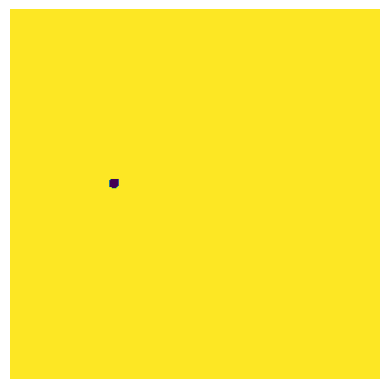

In [38]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(pred.permute(1, 2, 0).cpu().numpy())

tensor(255.)

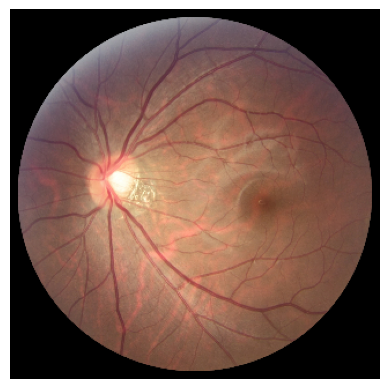

In [46]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img.int().permute(1, 2, 0).cpu().numpy())

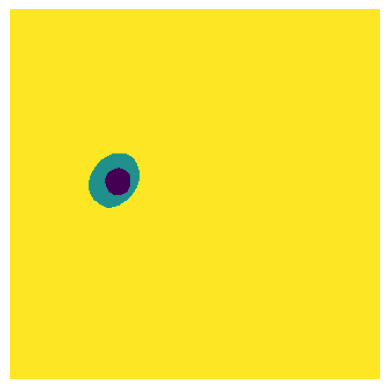

In [40]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(mask.unsqueeze(0).permute(1, 2, 0).cpu().numpy())